# Prediksi Status Penempatan Kerja Mahasiswa dengan Random Forest

Studi kasus: "Prediksi Status Penempatan Kerja Mahasiswa Menggunakan Algoritma Random Forest Berdasarkan Faktor Akademik dan Non-Akademik".

Notebook ini memuat:
- Import library
- Load dataset
- EDA singkat (info, missing value, distribusi target)
- Pra-pemrosesan data (imputasi median/mode, encoding LabelEncoder)
- Split data (train/test 80:20, stratify)
- Training model RandomForestClassifier
- Evaluasi (akurasi, classification report, confusion matrix)
- Feature importance
- ROC Curve & AUC
- Simpan model terbaik dengan joblib

## 1. Import Library

In [75]:
import os
import json

try:
    import joblib
except ModuleNotFoundError:
    import sys, subprocess
    print("joblib belum terpasang. Menginstal joblib...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib"])
    import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (8, 5)

## 2. Load Dataset

In [76]:
csv_path = r"C:\Users\X395\kuliah semester 5\PRAK_MACHINE_LEARNING\TUGAS 6\Placement_Data_Full_Class.csv"
assert os.path.exists(csv_path), f"File tidak ditemukan: {csv_path}"

df = pd.read_csv(csv_path)
print(f"Shape: {df.shape}")
df.head()

Shape: (215, 15)


,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


## 3. EDA Singkat (Info, Missing Value, Target)

In [77]:
print("== Info Dataset ==")
df.info()

print("\n== Jumlah Missing Value per Kolom ==")
print(df.isna().sum().sort_values(ascending=False))

candidate_names = [
    'status', 'Status', 'placed', 'Placed', 'placement_status', 'Placement Status'
]
y_col = None
for c in candidate_names:
    if c in df.columns:
        y_col = c
        break

if y_col is None:
   
    for c in df.columns:
        nunique = df[c].dropna().nunique()
        if nunique == 2 and df[c].dtype == 'O':
            y_col = c
            break


== Info Dataset ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB

== Jumlah Missing Value per Kolom ==
salary    

## 4. Visualisasi Target

C:\Users\X395\AppData\Local\Temp\ipykernel_16428\1997878740.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=y_col, palette=palette_main)
C:\Users\X395\AppData\Local\Temp\ipykernel_16428\1997878740.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.countplot(data=df, x=y_col, palette=palette_main)


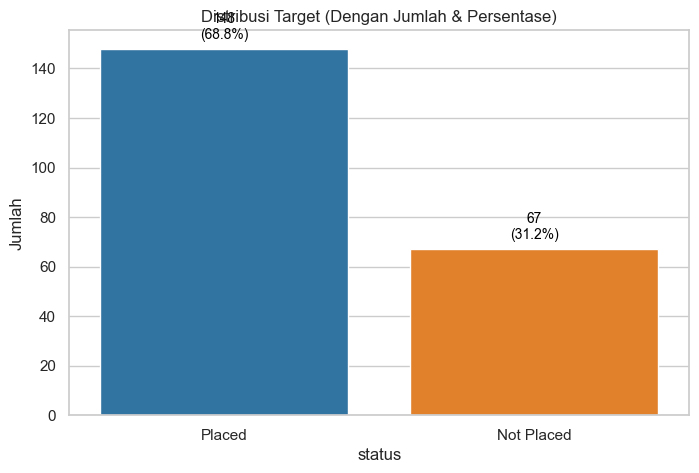

In [78]:
palette_main = sns.color_palette('tab10')

if 'y_col' in globals() and y_col is not None and y_col in df.columns:
    ax = sns.countplot(data=df, x=y_col, palette=palette_main)
    total = len(df)
    for p in ax.patches:
        count = int(p.get_height())
        pct = 100 * count / total if total else 0
        ax.annotate(f'{count}\n({pct:.1f}%)', (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
    plt.title('Distribusi Target (Dengan Jumlah & Persentase)')
    plt.xlabel(y_col)
    plt.ylabel('Jumlah')
    plt.show()

## 5. Histogram Fitur Numerik

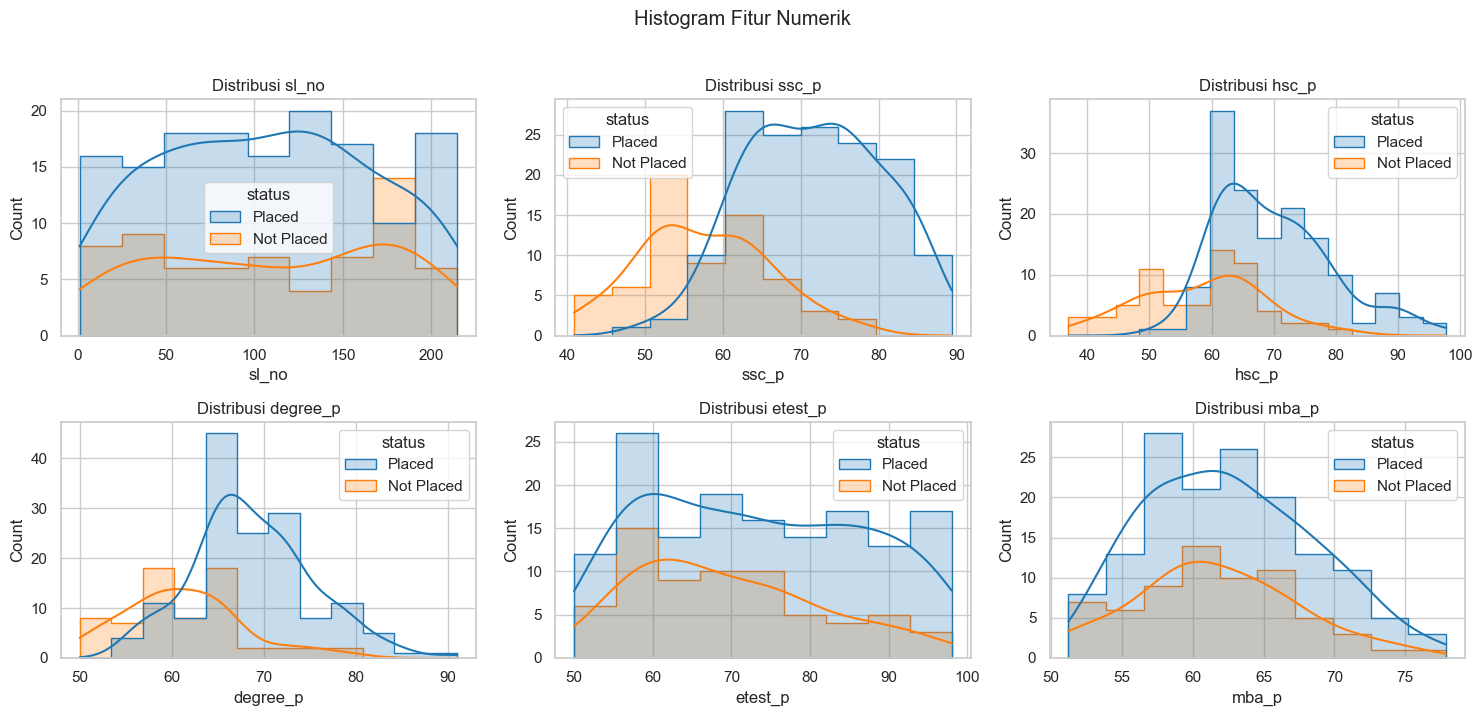

In [79]:
num_cols_viz = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols_viz) > 0:
    n = min(6, len(num_cols_viz))
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3.5))
    axes = axes.flatten()
    for i, c in enumerate(num_cols_viz[:n]):
        if 'y_col' in globals() and y_col is not None and y_col in df.columns and df[y_col].nunique() <= 10:
            sns.histplot(data=df, x=c, hue=y_col, kde=True, ax=axes[i], palette='tab10', element='step', stat='count')
        else:
            sns.histplot(data=df, x=c, kde=True, ax=axes[i], color=palette_main[i % len(palette_main)])
        axes[i].set_title(f'Distribusi {c}')
    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])
    fig.suptitle('Histogram Fitur Numerik', y=1.02)
    plt.tight_layout()
    plt.show()

## 5b. Heatmap Korelasi Fitur Numerik

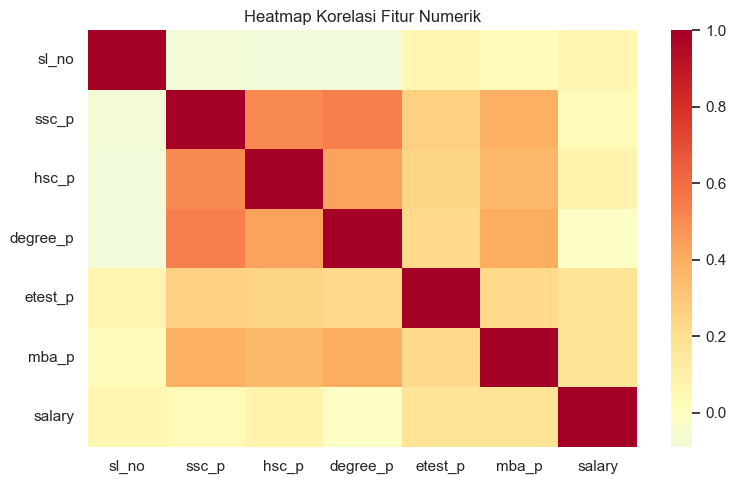

In [80]:
if len(num_cols_viz) >= 2:
    corr = df[num_cols_viz].corr(numeric_only=True)
    sns.heatmap(corr, annot=False, cmap='RdYlBu_r', center=0)
    plt.title('Heatmap Korelasi Fitur Numerik')
    plt.tight_layout()
    plt.show()

## 5c. Visualisasi Fitur Kategorikal

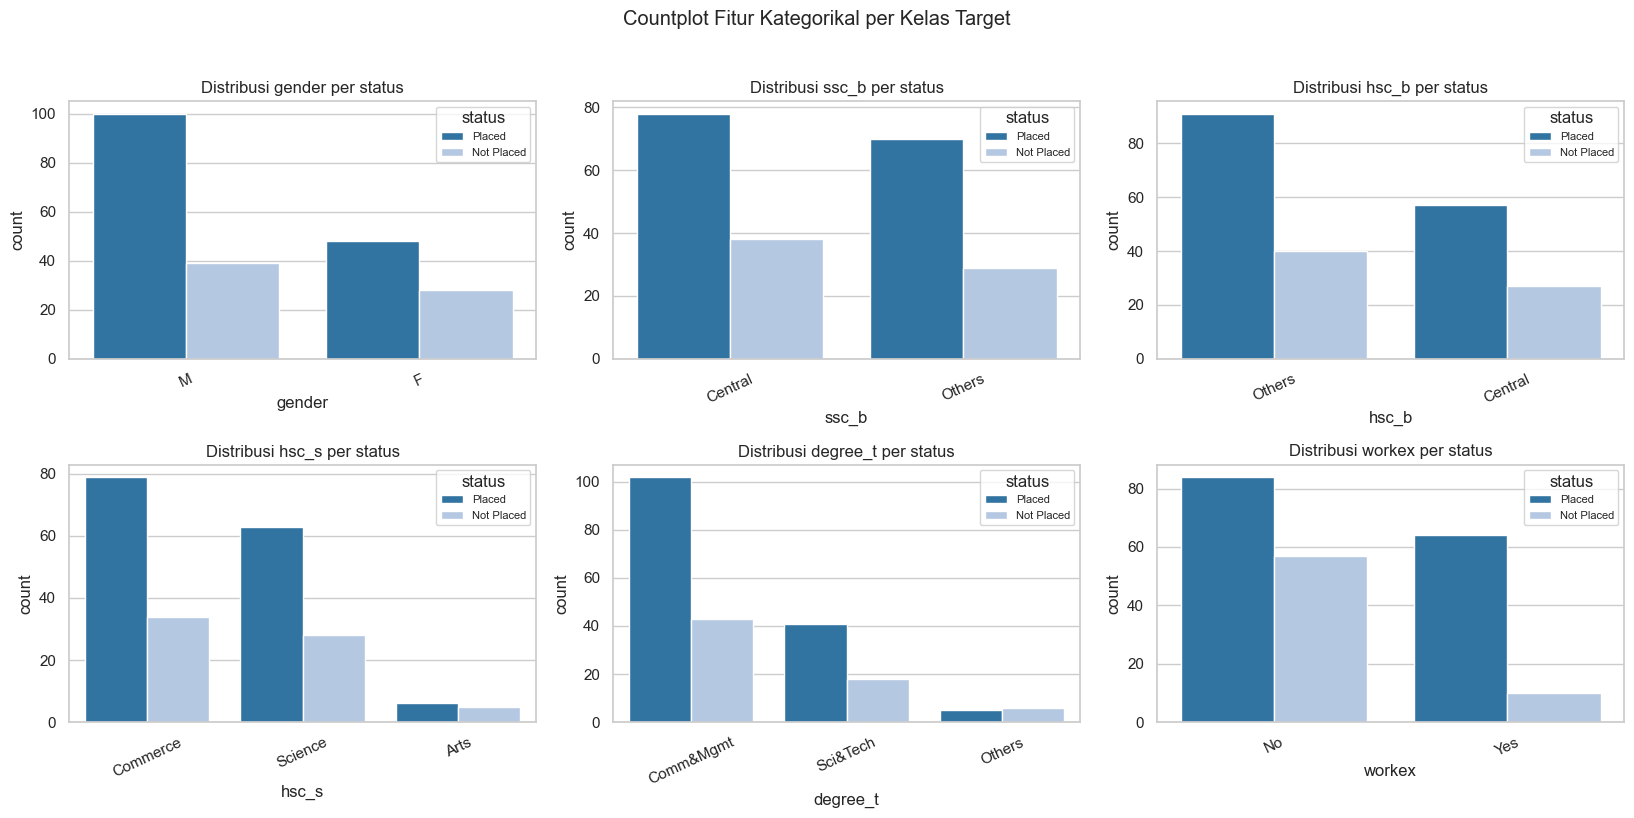

In [81]:
if 'y_col' in globals() and y_col is not None and y_col in df.columns:
    cat_cols_viz = df.select_dtypes(include=['object', 'category']).columns.tolist()
    cat_cols_viz = [c for c in cat_cols_viz if c != y_col]
    if len(cat_cols_viz) > 0:
        n = min(6, len(cat_cols_viz))
        cols = 3
        rows = int(np.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5.5, rows*4))
        axes = axes.flatten()
        for i, c in enumerate(cat_cols_viz[:n]):
            order = df[c].value_counts().index
            sns.countplot(data=df, x=c, hue=y_col, order=order, ax=axes[i], palette='tab20')
            axes[i].set_title(f'Distribusi {c} per {y_col}')
            axes[i].tick_params(axis='x', rotation=25)
            axes[i].legend(title=y_col, fontsize=8)
        for j in range(i+1, rows*cols):
            fig.delaxes(axes[j])
        fig.suptitle('Countplot Fitur Kategorikal per Kelas Target', y=1.02)
        plt.tight_layout()
        plt.show()

## 6. Pra-pemrosesan Data (Imputasi & Encoding)

In [82]:
# Pisahkan fitur dan target
# Drop kolom yang tidak diperlukan untuk prediksi
drop_cols = ['sl_no', 'salary']  # salary adalah target sekunder, tidak digunakan untuk prediksi status
if y_col:
    drop_cols.append(y_col)

X = df.drop(columns=drop_cols, errors='ignore')
y = df[y_col] if y_col else None

print(f"Fitur (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape if y is not None else 'None'}")
print(f"\nKolom fitur:\n{X.columns.tolist()}")

Fitur (X) shape: (215, 12)
Target (y) shape: (215,)

Kolom fitur:
['gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s', 'degree_p', 'degree_t', 'workex', 'etest_p', 'specialisation', 'mba_p']


In [83]:
# Identifikasi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Kolom numerik ({len(num_cols)}): {num_cols}")
print(f"Kolom kategorikal ({len(cat_cols)}): {cat_cols}")

# Imputasi missing values
fill_values = {}

# Untuk kolom numerik: isi dengan median
for col in num_cols:
    if X[col].isna().sum() > 0:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        fill_values[col] = median_val
        print(f"  - {col}: diisi dengan median = {median_val}")

# Untuk kolom kategorikal: isi dengan modus
for col in cat_cols:
    if X[col].isna().sum() > 0:
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)
        fill_values[col] = mode_val
        print(f"  - {col}: diisi dengan modus = {mode_val}")

print(f"\nMissing values setelah imputasi:\n{X.isna().sum().sum()}")

Kolom numerik (5): ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']
Kolom kategorikal (7): ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']

Missing values setelah imputasi:
0


In [84]:
# Encoding fitur kategorikal dengan LabelEncoder
encoders = {}
X_enc = X.copy()

for col in cat_cols:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X[col])
    encoders[col] = {
        'encoder': le,
        'classes_': le.classes_.tolist()
    }
    print(f"  - {col}: {len(le.classes_)} kelas -> {le.classes_.tolist()}")

# Encoding target
if y is not None:
    y_le = LabelEncoder()
    y_enc = y_le.fit_transform(y)
    y_encoder = {
        'encoder': y_le,
        'classes_': y_le.classes_.tolist()
    }
    print(f"\nTarget '{y_col}' encoded: {y_le.classes_.tolist()}")
else:
    y_enc = None
    y_encoder = None

# Simpan nama fitur untuk feature importance nanti
feature_names = X_enc.columns.tolist()

print(f"\nX_enc shape: {X_enc.shape}")
print(f"y_enc shape: {y_enc.shape if y_enc is not None else 'None'}")

  - gender: 2 kelas -> ['F', 'M']
  - ssc_b: 2 kelas -> ['Central', 'Others']
  - hsc_b: 2 kelas -> ['Central', 'Others']
  - hsc_s: 3 kelas -> ['Arts', 'Commerce', 'Science']
  - degree_t: 3 kelas -> ['Comm&Mgmt', 'Others', 'Sci&Tech']
  - workex: 2 kelas -> ['No', 'Yes']
  - specialisation: 2 kelas -> ['Mkt&Fin', 'Mkt&HR']

Target 'status' encoded: ['Not Placed', 'Placed']

X_enc shape: (215, 12)
y_enc shape: (215,)


# 7. Split Data (Train/Test 80:20, Stratify)

In [85]:
# Split data menjadi train dan test (80:20, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (172, 12)  Test shape: (43, 12)


## 8. Training Model RandomForestClassifier

In [86]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)
print(f"Akurasi Train: {train_acc:.4f}")
print(f"Akurasi Test : {test_acc:.4f}")

Akurasi Train: 1.0000
Akurasi Test : 0.8605


## 9. Evaluasi (Akurasi, Classification Report, Confusion Matrix)

Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.82      0.69      0.75        13
      Placed       0.88      0.93      0.90        30

    accuracy                           0.86        43
   macro avg       0.85      0.81      0.83        43
weighted avg       0.86      0.86      0.86        43



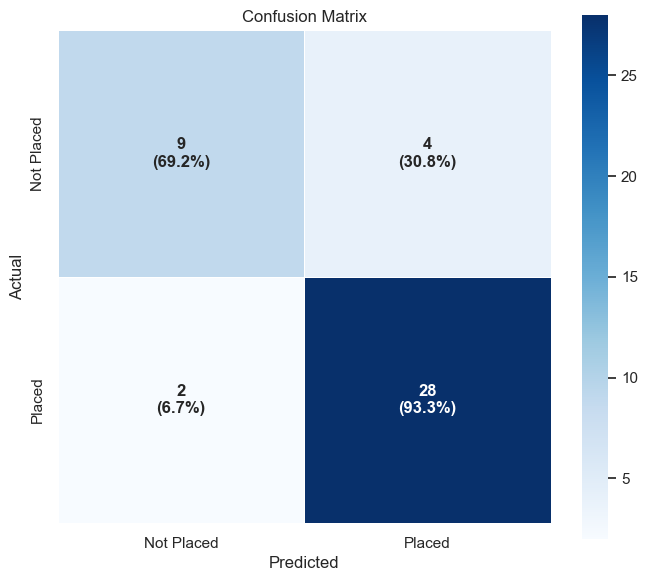

In [87]:
y_pred = rf.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=y_encoder['classes_']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
labels = y_encoder['classes_']

ann = np.empty_like(cm).astype(object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ann[i, j] = f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)"

plt.figure(figsize=(7, 6))
ax = sns.heatmap(cm, annot=ann, fmt="", cmap='Blues', linewidths=0.6, linecolor='white',
                 square=True, cbar=True,
                 xticklabels=labels,
                 yticklabels=labels,
                 annot_kws={"size":12, "weight":"bold"})
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

## 10. Feature Importance

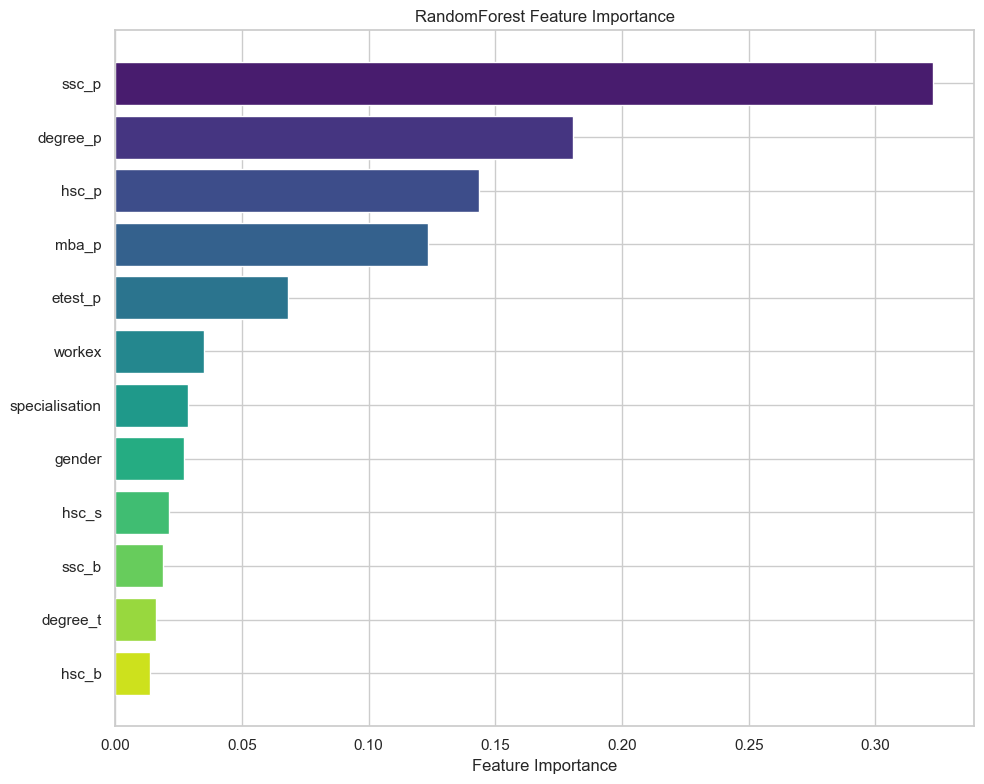

In [88]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10, 8))
    plt.title(f'{model_type} Feature Importance')
    plt.barh(fi_df['feature_names'], fi_df['feature_importance'], color=sns.color_palette('viridis', n_colors=len(fi_df)))
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf.feature_importances_, feature_names, 'RandomForest')

## 11. ROC Curve & AUC

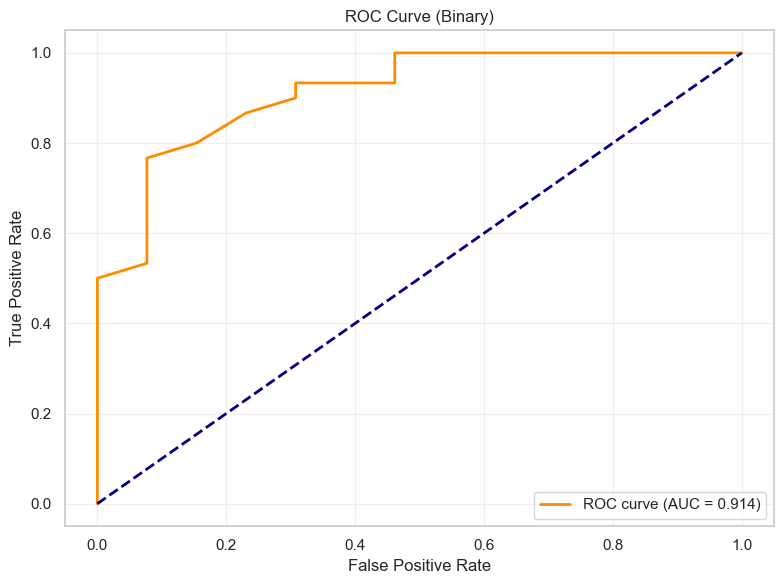

AUC: 0.9141


In [89]:
from sklearn.preprocessing import label_binarize

y_proba = rf.predict_proba(X_test)

classes = np.array(y_encoder['classes_'])

if y_proba.shape[1] == 2:
    # Binary classification
    y_score = y_proba[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"AUC: {roc_auc:.4f}")
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(y_proba.shape[1]))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(8, 6))
    for i in range(y_proba.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i] if i < len(classes) else i} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    macro_auc = np.mean(list(roc_auc.values()))
    print(f"Macro-average AUC: {macro_auc:.4f}")

## 12. Simpan Model Terbaik Menggunakan Joblib

In [90]:
artifact = {
    'model': rf,
    'feature_names': feature_names,
    'encoders': encoders,          
    'y_encoder': y_encoder,        
    'fill_values': fill_values, 
    'metadata': {
        'algorithm': 'RandomForestClassifier',
        'random_state': 42,
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc)
    }
}

save_path = 'model_random_forest.pkl'
joblib.dump(artifact, save_path)
print(f"Model dan metadata tersimpan ke: {os.path.abspath(save_path)}")

Model dan metadata tersimpan ke: c:\Users\X395\kuliah semester 5\PRAK_MACHINE_LEARNING\TUGAS 6\model_random_forest.pkl
